## 1. Import the Data Wrangling dataset and clean the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("https://drive.google.com/u/0/uc?id=1ZiqsLw5hH6Idbw7GxSLzA42Q3UsLyk8K&export=download")

In [ ]:
df.head()

,problem,domain,input_1,input_2,input_3,expected_output
0,addPunctuation-1,dates,290386,NaN,NaN,29-03-86
1,addPunctuation-1,dates,250374,NaN,NaN,25-03-74
2,addPunctuation-1,dates,170615,NaN,NaN,17-06-15
3,addPunctuation-1,dates,170905,NaN,NaN,17-09-05
4,addPunctuation-1,dates,241206,NaN,NaN,24-12-06


In [ ]:
df.describe()

,problem,domain,input_1,input_2,input_3,expected_output
count,3936,3936,3936,1120,192,3889
unique,119,7,2787,217,15,2498
top,convert-2,freetext,21:55,425,UTC,hotmail.com
freq,64,800,14,96,74,73


In [ ]:
df['expected_output'] = df['expected_output'].str.lstrip()

In [ ]:
df["input_2"].fillna("Null", inplace = True)
df["input_3"].fillna("Null", inplace = True)
df["expected_output"].fillna("", inplace = True)

In [ ]:
df

,problem,domain,input_1,input_2,input_3,expected_output
0,addPunctuation-1,dates,290386,Null,Null,29-03-86
1,addPunctuation-1,dates,250374,Null,Null,25-03-74
2,addPunctuation-1,dates,170615,Null,Null,17-06-15
3,addPunctuation-1,dates,170905,Null,Null,17-09-05
4,addPunctuation-1,dates,241206,Null,Null,24-12-06
...,...,...,...,...,...,...
3931,getValue-2,units,78 cal,Null,Null,78
3932,getValue-2,units,56776g,Null,Null,56676
3933,getValue-2,units,56ml,Null,Null,56
3934,getValue-2,units,7mol,Null,Null,7


In [ ]:
domains = df['domain'].drop_duplicates().to_list()

## 2. Perform the problem and example sampling and build the different GPT-3 prompts

In [ ]:
import random as rn

final_problems = []

for i in range(0, len(domains)):
  print("Domain: " + domains[i])
  sel_prob = df[['problem','domain']].query('domain == "' + domains[i] + '"')['problem'].drop_duplicates().to_list()
  print("Problems: " + str(sel_prob))
  for j in range(0,len(sel_prob)):
    sel_prob[j] = [sel_prob[j],domains[i]]
  final_problems = final_problems + sel_prob


Domain: dates
Problems: ['addPunctuation-1', 'addPunctuation-2', 'changeFormat-1', 'changeFormat-2', 'changeFormat-3', 'changeFormat-4', 'changePunctuation-1', 'changePunctuation-2', 'getDay-1', 'getDay-2', 'getDay-3', 'getDayOrdinal-1', 'getDayOrdinal-2', 'getMonthName-1', 'getMonthName-2', 'getWeekDay-1', 'getWeekDay-2', 'reduceMonthName-1', 'reduceMonthName-2', 'setFormat-1', 'setFormat-2']
Domain: emails
Problems: ['generate-1', 'generate-2', 'generate-3', 'getAfterAt-1', 'getAfterAt-2', 'getAfterAt-3', 'getAfterAt-4', 'getDomain-1', 'getDomain-2', 'someBeforeAt-NA']
Domain: freetext
Problems: ['afterSymbol-1', 'afterSymbol-2', 'betweenSymbols-1', 'betweenSymbols-2', 'brackets-1', 'brackets-2', 'deletePunctuation-1', 'deletePunctuation-2', 'deletePunctuation-3', 'deletePunctuation-4', 'deleteSpaces-1', 'deleteSpaces-2', 'digitToEnd-1', 'digitToEnd-2', 'firstCharacter-1', 'firstCharacter-2', 'getAfterComma-1', 'getAfterComma-2', 'getBetweenCommas-1', 'getBetweenCommas-2', 'getCaps-1

In [ ]:
len(final_problems)

123

In [ ]:
sum = 0
for i in range(0, len(domains)):
  for j in range(0, len(final_problems)):
    if final_problems[j][1] == domains[i]:
      sum = sum + 1
  print("Domain " + domains[i] + ": " + str(sum))
  sum = 0

Domain dates: 21
Domain emails: 10
Domain freetext: 25
Domain names: 15
Domain phones: 18
Domain times: 24
Domain units: 10


The code below is for the case when there is a need of spliting the dataset

IGNORE

def Diff(li1, li2):
    li_dif = [i for i in li1 if i in li1 and i not in li2]
    return li_dif
 
import random as rn
import math
 
test_problems = []
training_problems = []

seed = 97
 
for i in range(0, len(domains)):
  sel_prob = df[['problem','domain']].query('domain == "' + domains[i] + '"')['problem'].drop_duplicates().to_list()
  rn.seed(seed)
  test_samp = rn.sample(sel_prob,math.ceil(0.3*len(sel_prob)))
  training_samp = Diff(sel_prob,test_samp)
  for j in range(0,len(test_samp)):
    test_samp[j] = [test_samp[j],domains[i]]
  test_problems = test_problems + test_samp
  for j in range(0,len(training_samp)):
    training_samp[j] = [training_samp[j],domains[i]]
  training_problems = training_problems + training_samp

In [ ]:
#Prompt generator

maxShots = 10
seed = 97
numExamples = 32

queries = [[]]*(maxShots+1)
test_targets = [[]]*(maxShots+1)
common_prompt = [[]]*(maxShots+1)


for s in range(0,maxShots+1):

  queries[s] = [[]]*len(final_problems)
  test_targets[s] = [[]]*len(final_problems)
  common_prompt[s] = [""]*len(final_problems)

  for i in range(0, len(final_problems)):
    #Extract examples from DataFrame 
    input1 = df.query('problem == "' + final_problems[i][0] + '" and domain == "' + final_problems[i][1] + '"')['input_1'].to_list()
    input2 = df.query('problem == "' + final_problems[i][0] + '" and domain == "' + final_problems[i][1] + '"')['input_2'].to_list()
    input3 = df.query('problem == "' + final_problems[i][0] + '" and domain == "' + final_problems[i][1] + '"')['input_3'].to_list()
    output = df.query('problem == "' + final_problems[i][0] + '" and domain == "' + final_problems[i][1] + '"')['expected_output'].to_list()

    #Retrieve the trainingNum examples positions in the list
    #It could be out of the loop (it will always be the same)
    unsampled_pos = list(range(0, numExamples))
    sampled_pos = []
    for j in range(0, s):
      rn.seed(seed)
      pos = rn.choice(unsampled_pos)
      sampled_pos.append(pos)
      unsampled_pos.remove(pos)


    final_input_1 = []
    final_input_2 = []
    final_input_3 = []
    final_output = []

    #Extract

    for j in range(0, s):
      final_input_1.append(input1[sampled_pos[j]])
      final_input_2.append(input2[sampled_pos[j]])
      final_input_3.append(input3[sampled_pos[j]])
      final_output.append(output[sampled_pos[j]])

    sampled_pos = sorted(sampled_pos, reverse=True)

    for j in range(0, s):
      del input1[sampled_pos[j]]
      del input2[sampled_pos[j]]
      del input3[sampled_pos[j]]
      del output[sampled_pos[j]]

    #Common prompt builder

    for j in range(0, s):
        if final_input_2[j] != "Null" and final_input_3[j] != "Null":
          common_prompt[s][i] = common_prompt[s][i] + "Input: " + str(final_input_1[j]) + "; " + str(final_input_2[j]) + "; " + str(final_input_3[j]) + "\nOutput: " + str(final_output[j]) + "\n\n"
        elif final_input_2[j] != "Null":
          common_prompt[s][i] = common_prompt[s][i] + "Input: " + str(final_input_1[j]) + "; " + str(final_input_2[j]) + "\nOutput: " + str(final_output[j]) + "\n\n"
        else:
          common_prompt[s][i] = common_prompt[s][i] + "Input: " + str(final_input_1[j]) + "\nOutput: " + str(final_output[j]) + "\n\n"


    #Queries building

    queries[s][i] = [""]*len(input1)
    test_targets[s][i] = [""]*len(input1)

    for j in range(0, len(input1)):
        if input2[j] != "Null" and input3[j] != "Null":
          queries[s][i][j] = common_prompt[s][i] + "Input: " + str(input1[j]) + "; " + str(input2[j]) + "; " + str(input3[j]) + "\nOutput:"
        elif input2[j] != "Null":
          queries[s][i][j] = common_prompt[s][i] + "Input: " + str(input1[j]) + "; " + str(input2[j]) + "\nOutput:"
        else:
          queries[s][i][j] = common_prompt[s][i] + "Input: " + str(input1[j]) + "\nOutput:"

        test_targets[s][i][j] = output[j]

  

In [ ]:
#Create queries file

maxShots = 10
numExamples = 32

text_file = open("queries" + ".csv", "w")
text_file.write('"' + "nshot" + '","' + "problem" + '","' + "domain" + '","' + "query" + '"\n')
for s in range(0, maxShots+1):
  for i in range(0, len(final_problems)):
    for j in range(0,numExamples-s):
      text_file.write('"' + str(s) + '","' + final_problems[i][0] + '","' + final_problems[i][1] + '",' + repr(queries[s][i][j]).replace("'",'"') + "\n")
text_file.close()

# 3. Execute GPT-3

In [ ]:
!pip install openai

     |████████████████████████████████| 155 kB 5.1 MB/s 
     |████████████████████████████████| 11.5 MB 225 kB/s 
     |████████████████████████████████| 157 kB 50.7 MB/s 
     |████████████████████████████████| 243 kB 49.5 MB/s 
  Created wheel for openai: filename=openai-0.10.1-py3-none-any.whl size=167551 sha256=9df43a107a72a1b15f39562305ec5f6961f4342d069bd9e68a450150e2bfc1df
  Stored in directory: /root/.cache/pip/wheels/06/90/44/74a9536b153b7ca2fcadaf316a552a2018fd298b95c153af05
Successfully built openai
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflict

In [ ]:
import argparse
import openai
import os
import numpy as np
import pandas as pd
import time
 
maxShots = 10
numExamples = 32
 
openai.api_key = "COMPLETE"
 
engines = ["davinci","curie","babbage","ada"]
 
outputs = [[]]*(maxShots+1)
probs = [[]]*(maxShots+1)
 
for s in range(0, maxShots+1):
    #print(str(s) + "-shots")
    outputs[s] = [[]]*len(engines)
    probs[s] = [[]]*len(engines)
    for e in range(0, len(engines)):
      text_file = open("out_prob_" + str(s) + "_" + engines[e] + ".csv", "w")
      #print("Engine: " + engines[e])
      outputs[s][e] = [[]]*len(final_problems)
      probs[s][e] = [[]]*len(final_problems)
      for i in range(0, len(final_problems)):
        outputs[s][e][i] = [""]*(numExamples-s)
        probs[s][e][i] = [""]*(numExamples-s)
        for j in range(0,numExamples-s):
            c = openai.Completion.create(
                                engine=engines[e],
                                prompt=queries[s][i][j],
                                max_tokens=75,
                                temperature=0,
                                stop=["\n"],
                                logprobs = 1
                                )
            
            outputs[s][e][i][j] = c['choices'][0]['text']
            prob = 1
            n = 0
            while n < len(c['choices'][0]['logprobs']['tokens']):
              if c['choices'][0]['logprobs']['tokens'][n] == "\n":
                n = len(c['choices'][0]['logprobs']['tokens'])
              else:
                prob = prob * pow(2,c['choices'][0]['logprobs']['token_logprobs'][n])
                n = n + 1
            probs[s][e][i][j] = prob
 
            text_file.write('"' + final_problems[i][0] + '","' + final_problems[i][1] + '","' + outputs[s][e][i][j] + '","' + str(probs[s][e][i][j]) + '"\n')
 
      text_file.close()

# 4. Evaluation

In [ ]:
import numpy

maxShots = 10
numExamples = 32

thresholds = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
engines = ["davinci","curie","babbage","ada"]

corrects = [[]]*(maxShots+1)
incorrects = [[]]*(maxShots+1)
rejects = [[]]*(maxShots+1)

for s in range(0, maxShots+1):
  corrects[s] = [[]]*len(engines)
  incorrects[s] = [[]]*len(engines)
  rejects[s] = [[]]*len(engines)
  for e in range(0, len(engines)):
    corrects[s][e] = [[]]*len(thresholds)
    incorrects[s][e] = [[]]*len(thresholds)
    rejects[s][e] = [[]]*len(thresholds)
    for t in range(0, len(thresholds)):
      corrects[s][e][t] = [[]]*len(final_problems)
      incorrects[s][e][t] = [[]]*len(final_problems)
      rejects[s][e][t] = [[]]*len(final_problems)
      for i in range(0, len(final_problems)):
        corrects[s][e][t][i] = [0]*(numExamples-s)
        incorrects[s][e][t][i] = [0]*(numExamples-s)
        rejects[s][e][t][i] = [0]*(numExamples-s)
        for j in range(0, numExamples-s):
          if isinstance(outputs[s][e][i][j],float):
            if numpy.isnan(outputs[s][e][i][j]):
              outputs[s][e][i][j] = ""
          if probs[s][e][i][j] >= thresholds[t]:
            if outputs[s][e][i][j].lstrip() == test_targets[s][i][j]:
              corrects[s][e][t][i][j] = 1
            else:
              incorrects[s][e][t][i][j] = 1
          else:
            rejects[s][e][t][i][j] = 1

In [ ]:
#Create evaluation file

maxShots = 10
numExamples = 32

thresholds = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
engines = ["davinci","curie","babbage","ada"]

text_file = open("eval.csv", "w")
text_file.write('"' + "nshot" + '","' + "engine" + '","' + "problem" + '","' + "domain" + '","' + "threshold" + '","' + "correct" + '","' + "incorrect" + '","' + "reject" + '"\n')
for s in range(0, maxShots+1):
  for e in range(0, len(engines)):
    for t in range(0, len(thresholds)):
      for i in range(0, len(final_problems)):
        for j in range(0,numExamples-s):
          text_file.write('"' + str(s) + '","' + engines[e] + '","' + final_problems[i][0] + '","' + final_problems[i][1] + '","' + str(thresholds[t]) + '","' + str(corrects[s][e][t][i][j]) + '","' + str(incorrects[s][e][t][i][j]) + '","' + str(rejects[s][e][t][i][j]) + '"\n')
text_file.close()

In [ ]:
#Create full experiment file

maxShots = 10
numExamples = 32

thresholds = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
engines = ["davinci","curie","babbage","ada"]

text_file = open("complete" + ".csv", "w")
text_file.write('"' + 'problem' + '","' + 'domain' + '","' + 'engine' + '","' + 'nshot' + '","' + 'threshold' + '","' + 'query' + '","' + 'target' + '","' + 'output' + '","' + 'prob' + '","' + 'correct' + '","' + 'incorrect' + '","' + 'reject' + '"\n')
for s in range(0, maxShots+1):
  for e in range(0, len(engines)):
    for t in range(0, len(thresholds)):
      for i in range(0, len(final_problems)):
        for j in range(0,numExamples-s):
          text_file.write('"' + final_problems[i][0] + '","' + final_problems[i][1] + '","' + engines[e] + '","' + str(s) + '","' + str(thresholds[t]) + '",' + repr(queries[s][i][j]).replace("'",'"') + ',"' + test_targets[s][i][j] + '","' + outputs[s][e][i][j].lstrip() + '","' + str(probs[s][e][i][j]) + '","' + str(corrects[s][e][t][i][j]) + '","' + str(incorrects[s][e][t][i][j]) + '","' + str(rejects[s][e][t][i][j]) + '"\n')
text_file.close()

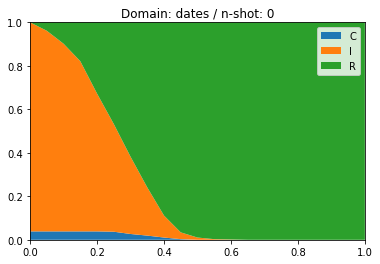

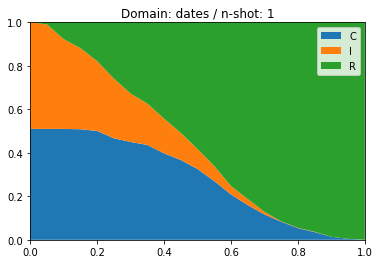

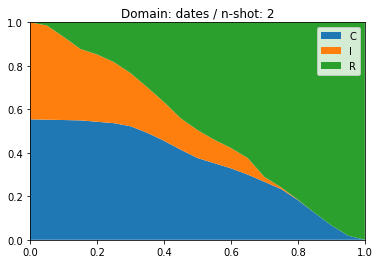

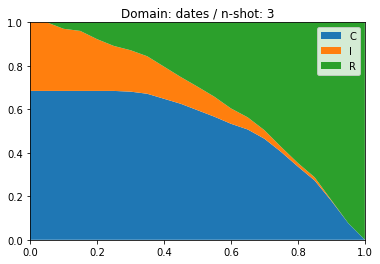

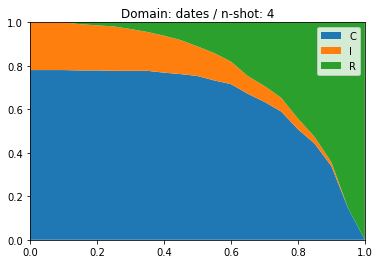

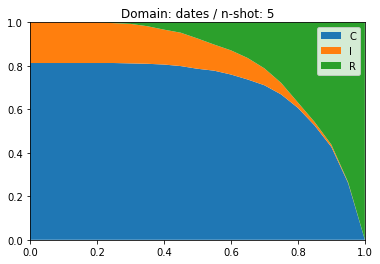

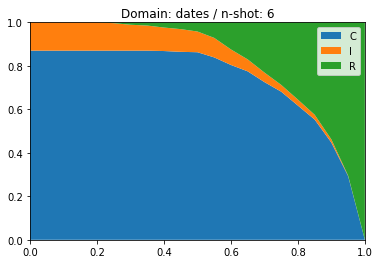

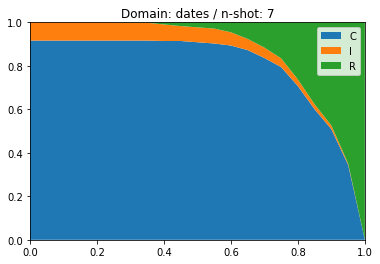

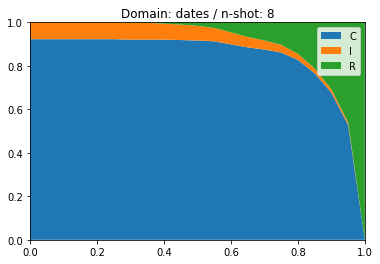

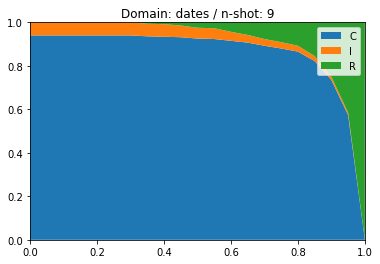

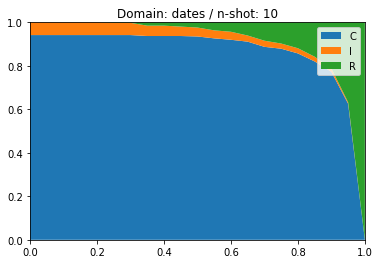

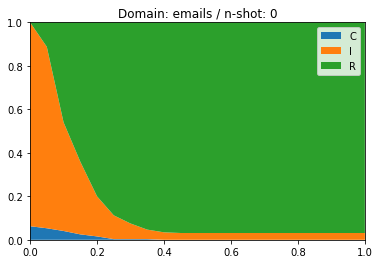

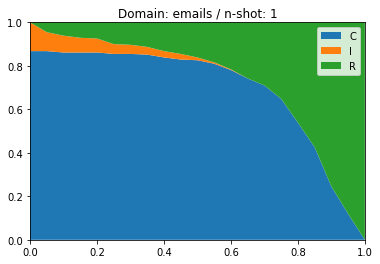

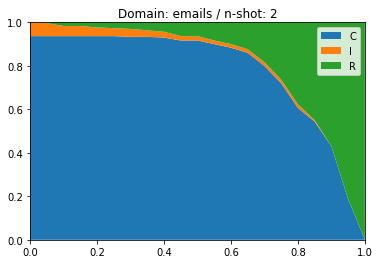

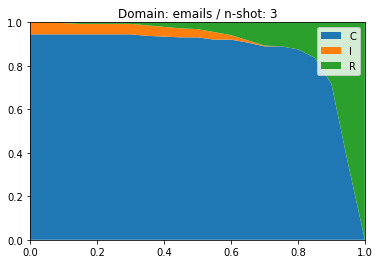

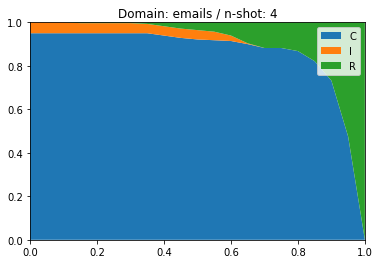

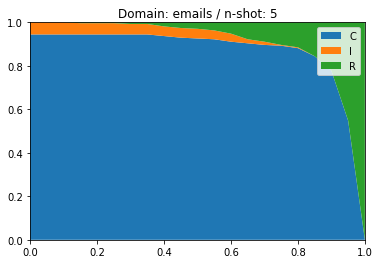

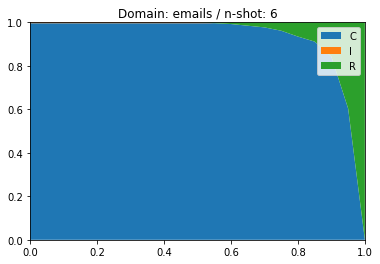

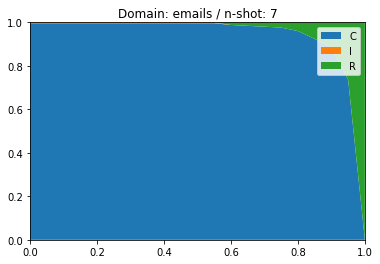

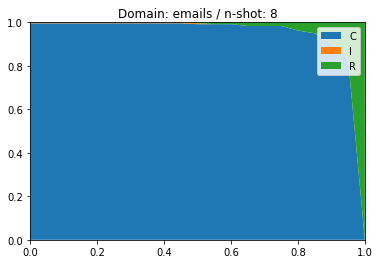

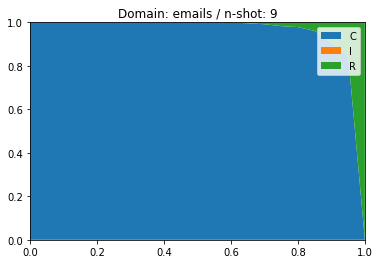

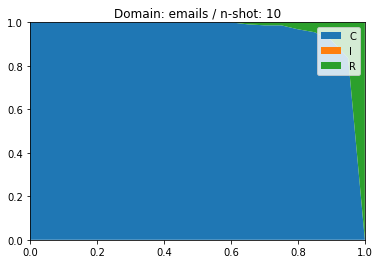

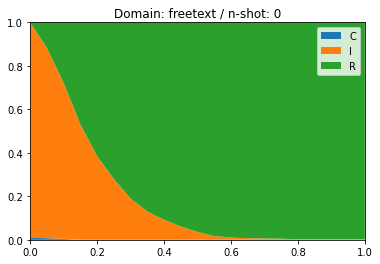

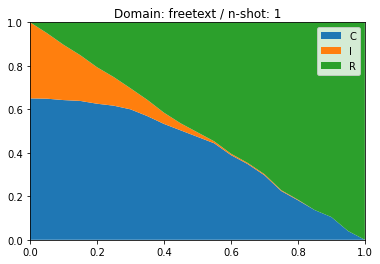

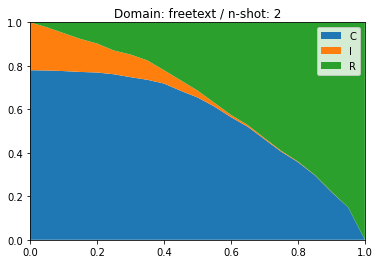

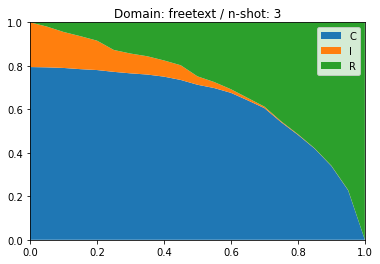

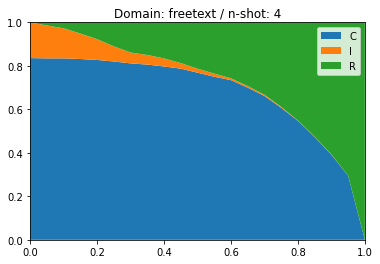

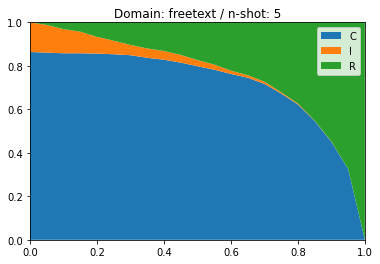

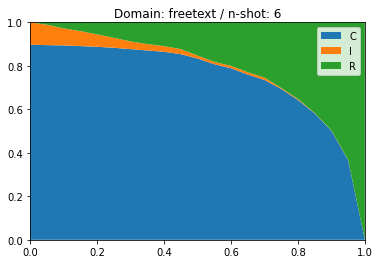

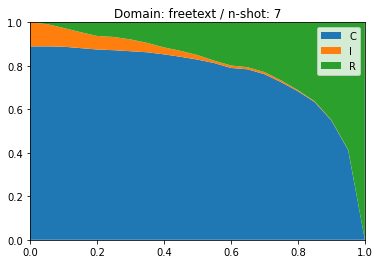

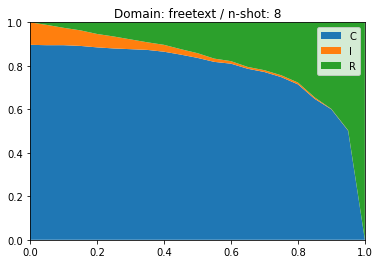

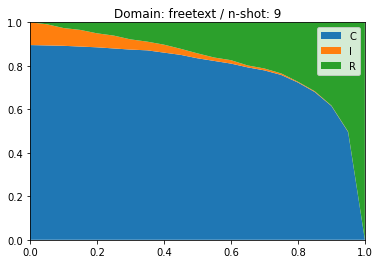

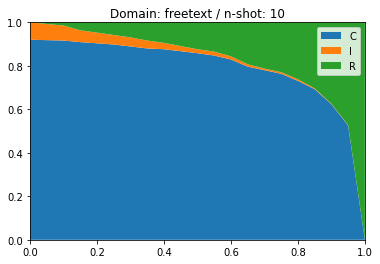

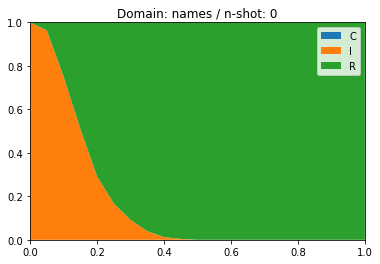

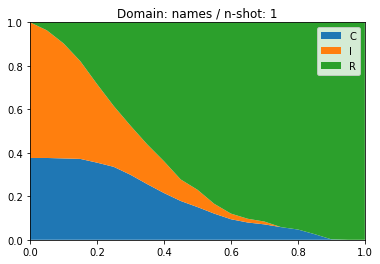

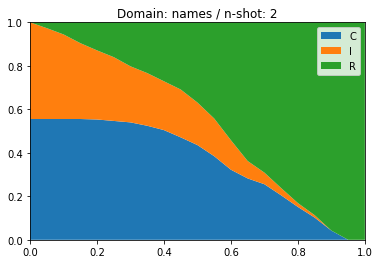

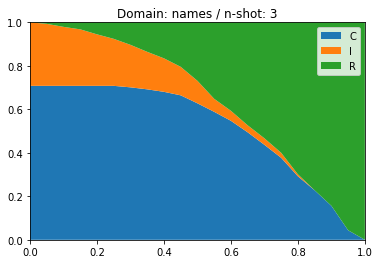

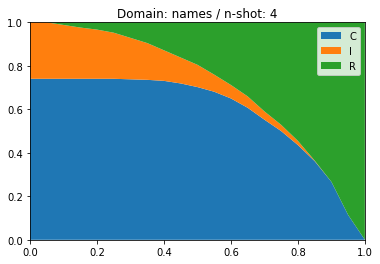

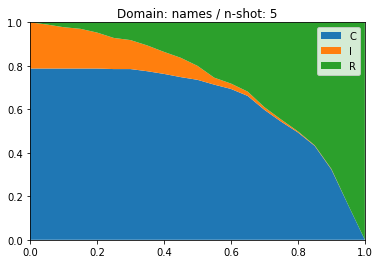

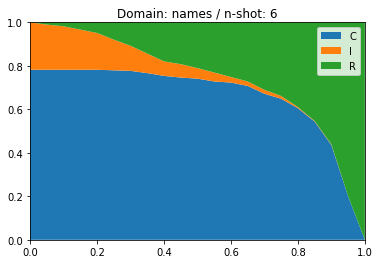

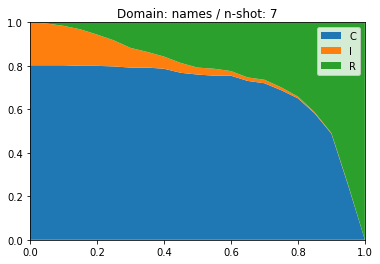

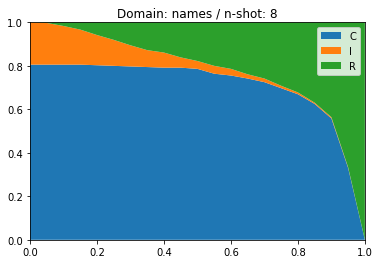

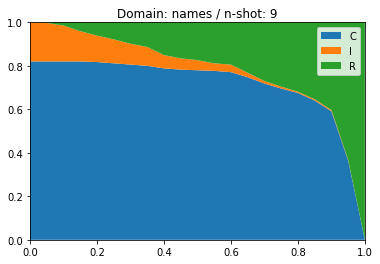

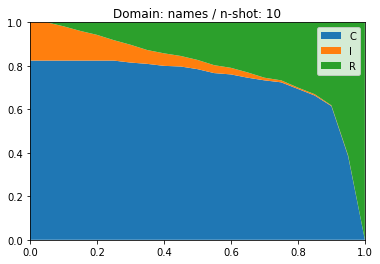

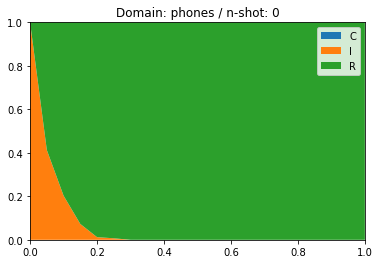

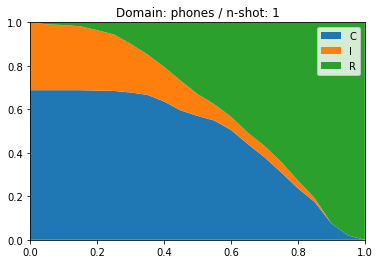

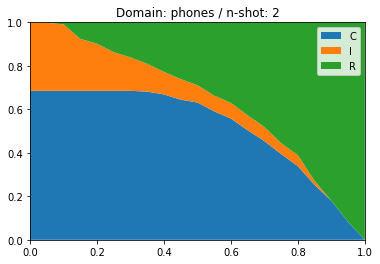

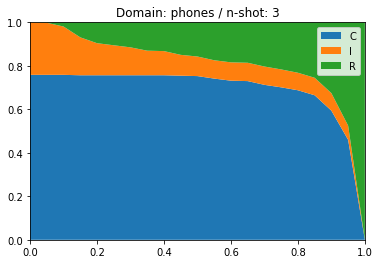

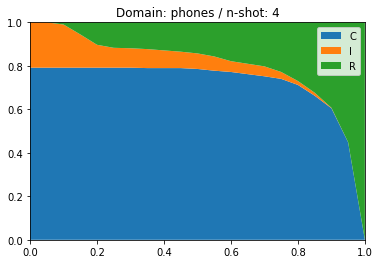

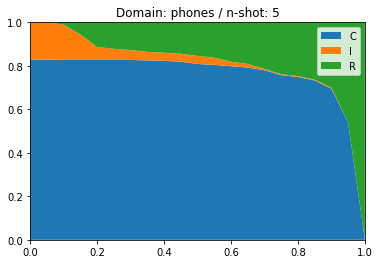

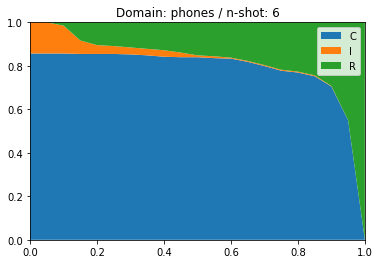

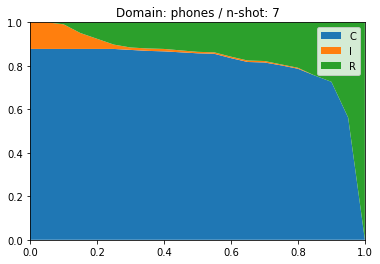

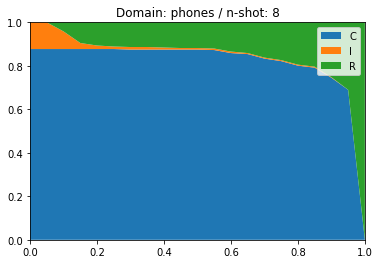

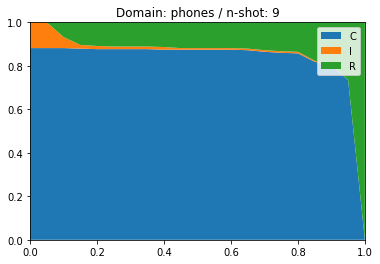

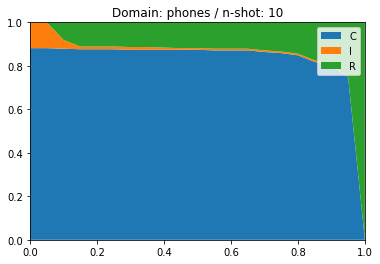

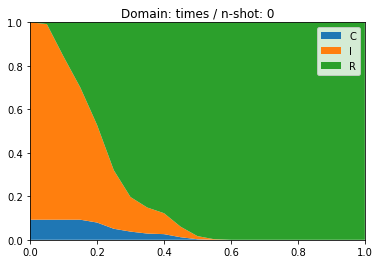

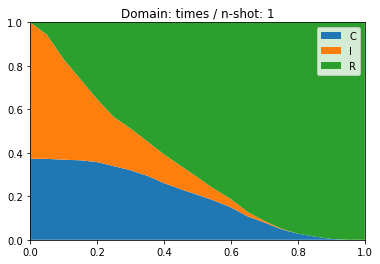

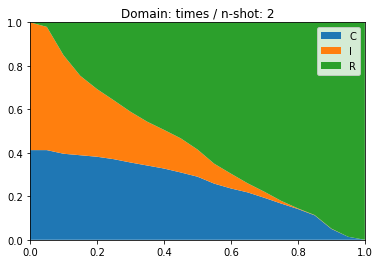

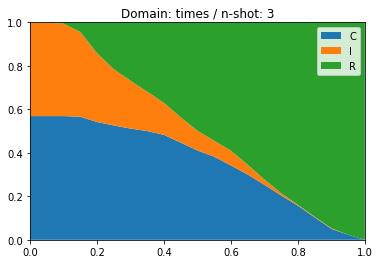

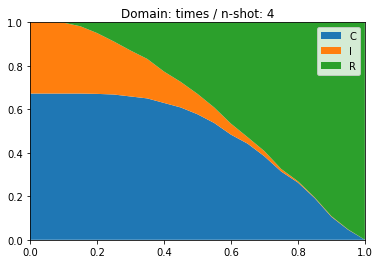

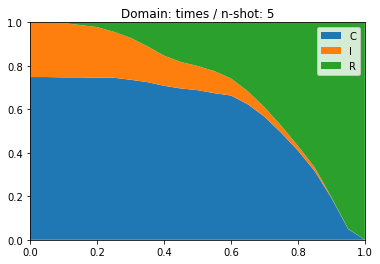

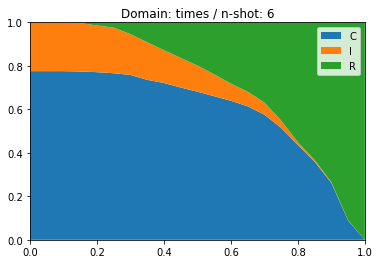

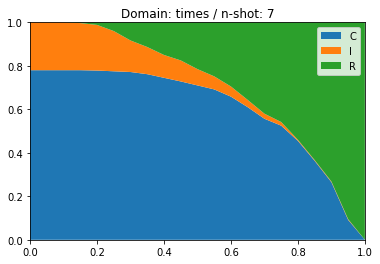

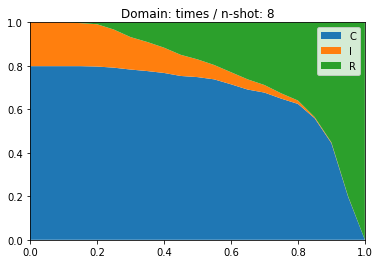

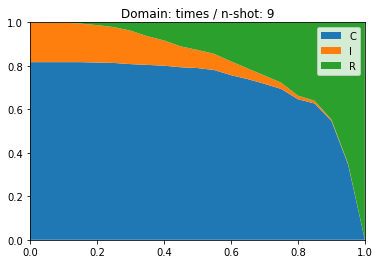

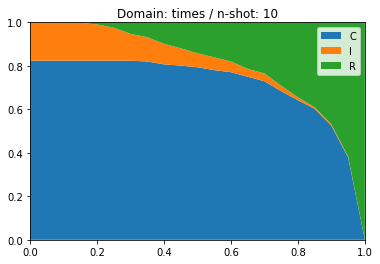

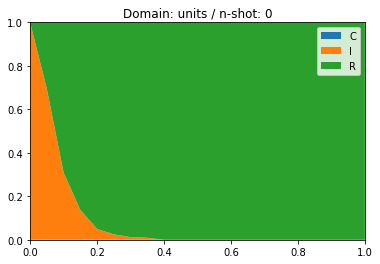

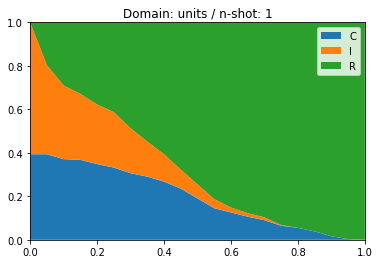

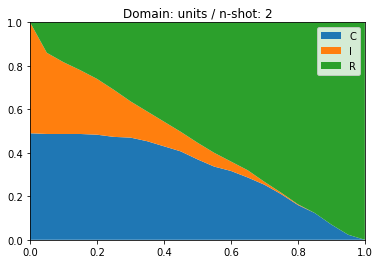

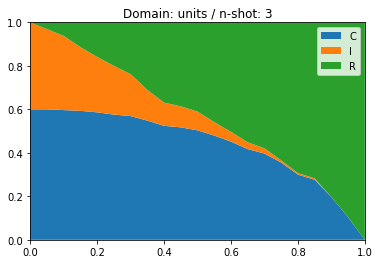

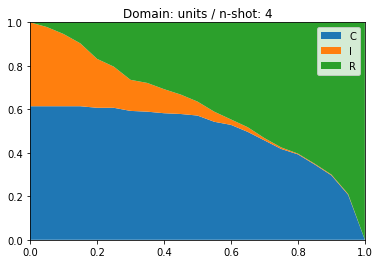

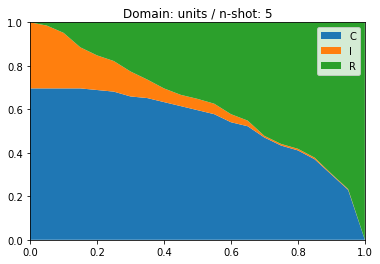

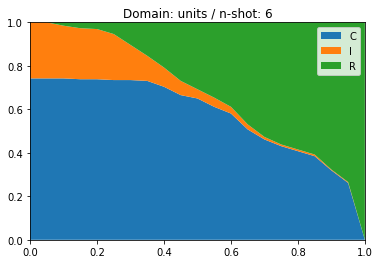

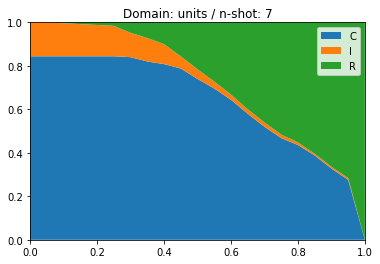

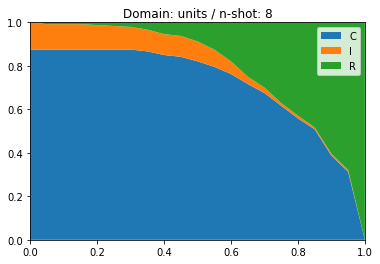

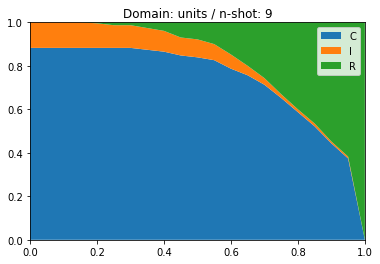

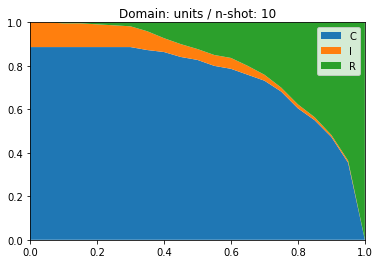

In [ ]:
# Print correct / incorrect / areas plots
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv('complete.csv')
aux = data.query('engine == "davinci"').groupby(['domain','nshot','threshold']).sum()[['correct','incorrect','reject']]
aux = aux.div(aux.sum(axis=1), axis=0)

maxShots = 10
thresholds = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
engines = ["davinci"]
domains = data['domain'].drop_duplicates().to_list()

for i in range(0, len(domains)):
  for j in range(0, maxShots+1):
      sel_df = aux.query('domain == "' + domains[i] + '" and nshot == ' + str(j))
      plt.stackplot(thresholds,  sel_df["correct"],  sel_df["incorrect"],  sel_df["reject"], labels=['C','I','R'])
      plt.legend(loc='upper right')
      plt.margins(0,0)
      plt.title("Domain: " + domains[i] + " / n-shot: " + str(j))
      plt.show()   

In [ ]:
# Correlation study

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv('complete.csv')
aux = data.query('engine == "davinci"').groupby(['domain','nshot','threshold']).sum()[['correct','incorrect','reject']]
aux = aux.div(aux.sum(axis=1), axis=0)
prob_aux = data.query('engine == "davinci"').groupby(['domain','nshot']).mean()[['prob']]

domains = data['domain'].drop_duplicates().to_list()

test = pd.DataFrame()

for i in range(0, len(domains)):
    test = pd.concat([test,pd.concat([aux.query('domain == "' + domains[i] + '" and threshold == 0').reset_index()[['correct','nshot']],prob_aux.query('domain == "' + domains[i] + '"').reset_index()['prob']], axis=1)])
    
corrM = test.corr()
print("Corr Matrix")
print(corrM)
print("\n")

Corr Matrix
          correct     nshot      prob
correct  1.000000  0.745393  0.976849
nshot    0.745393  1.000000  0.790147
prob     0.976849  0.790147  1.000000




In [ ]:
data = pd.read_csv('complete.csv')
aux = data.query('engine == "davinci"').groupby(['domain','nshot','threshold']).sum()[['correct','incorrect','reject']]
aux = aux.div(aux.sum(axis=1), axis=0)
prob_aux = data.query('engine == "davinci"').groupby(['domain','nshot']).mean()[['prob']]

In [ ]:
pd.set_option('display.max_rows', None)
prob_aux

prob
domain   nshot          
dates    0      0.259004
         1      0.436413
         2      0.516101
         3      0.642646
         4      0.773228
         5      0.815557
         6      0.823472
         7      0.863627
         8      0.901643
         9      0.914181
         10     0.915580
emails   0      0.155177
         1      0.725803
         2      0.810767
         3      0.886406
         4      0.892899
         5      0.905432
         6      0.936701
         7      0.948808
         8      0.957903
         9      0.964272
         10     0.965852
freetext 0      0.192373
         1      0.494640
         2      0.631537
         3      0.698131
         4      0.728332
         5      0.766332
         6      0.785019
         7      0.797955
         8      0.815588
         9      0.821156
         10     0.831494
names    0      0.165547
         1      0.347441
         2      0.543874
         3      0.639156
         4      0.709485
         5      0.717886
         6      0.743044
         7      0.760646
         8      0.779189
         9      0.785650
         10     0.792849
phones   0      0.061395
         1      0.617699
         2      0.639028
         3      0.812205
         4      0.805207
         5      0.814326
         6      0.824374
         7      0.837799
         8      0.850621
         9      0.867000
         10     0.864825
times    0      0.221785
         1      0.347558
         2      0.427716
         3      0.511820
         4      0.609193
         5      0.702637
         6      0.716623
         7      0.705779
         8      0.770007
         9      0.809280
         10     0.805148
units    0      0.083478
         1      0.326181
         2      0.452371
         3      0.567889
         4      0.610200
         5      0.625191
         6      0.672689
         7      0.719316
         8      0.789536
         9      0.812331
         10     0.807712